In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from insightdemo.utils import mathy_header, plot_roc_curve, plot_learning_curve

# Load Dataset

In [7]:
# Download dataset
hsa_dataset = pd.read_excel("https://ndownloader.figshare.com/files/5324491", None)

In [8]:
# Let's take a quick look
data = hsa_dataset["All"]
mathy_header(data)
data.head()

,Protein,index,type,x,y,z,occ,$E_{sw}$,$E_{ww}$,$E_{tot}$,$E^{nbr}_{ww}$,$N^{nbrs}$,$f_{enc}$,$N^{HB}_{sw}$,$N^{HB}_{ww}$,$f^{HB}_{ww}$,"$N^{HB}_{ww,lost}$",lig_contact,t_statistic,p_value
0,abl,0,C2F,-1.90,-12.30,-0.79,0.9234,-7.886070,-2.330430,-10.216500,-1.237988,2.363223,0.549862,1.595408,1.367122,57.849876,1.831040,not_displaced,39.731908,0.000000e+00
1,abl,1,C2F,-5.63,-4.61,-4.35,0.9246,-9.815779,-0.801470,-10.617249,-1.119749,2.431322,0.537030,1.587822,1.556781,64.030249,1.788310,not_displaced,57.148045,0.000000e+00
2,abl,2,C1F,-3.59,-9.44,-1.87,0.9148,-7.585982,-4.115125,-11.701107,-1.462429,2.996174,0.429581,1.879974,1.990162,66.423438,1.430505,hydrophilic,117.529066,0.000000e+00
3,abl,3,C2F,-9.49,-4.17,-5.07,0.9068,-10.545356,0.613647,-9.931709,-0.620995,3.208866,0.391129,1.483569,1.650088,51.422778,1.302460,not_displaced,21.260681,5.495392e-99
4,abl,4,P1U,1.31,-8.94,-6.30,0.8894,-4.102407,-5.039672,-9.142079,-2.175132,1.981785,0.622517,0.945919,1.753429,88.477250,2.072982,not_displaced,-22.268783,1.752911e-108


In [10]:
# Preprocess Data
print(data.isnull().sum())
data = data.dropna(axis=0)
labels = data["lig_contact"] != "not_displaced"
data.insert(1, "category", labels.values)

Protein               0
index                 0
type                  0
x                     0
y                     0
z                     0
occ                   0
$E_{sw}$              0
$E_{ww}$              0
$E_{tot}$             0
$E^{nbr}_{ww}$        0
$N^{nbrs}$            0
$f_{enc}$             0
$N^{HB}_{sw}$         0
$N^{HB}_{ww}$         0
$f^{HB}_{ww}$         1
$N^{HB}_{ww,lost}$    0
lig_contact           0
t_statistic           0
p_value               0
dtype: int64


In [19]:
data.loc[:, 1] = data.category.astype(int)
data.head()

/Users/kamranhaider/anaconda3/envs/demo/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,Protein,category,index,type,x,y,z,occ,$E_{sw}$,$E_{ww}$,...,$N^{nbrs}$,$f_{enc}$,$N^{HB}_{sw}$,$N^{HB}_{ww}$,$f^{HB}_{ww}$,"$N^{HB}_{ww,lost}$",lig_contact,t_statistic,p_value,1
0,abl,0,0,C2F,-1.90,-12.30,-0.79,0.9234,-7.886070,-2.330430,...,2.363223,0.549862,1.595408,1.367122,57.849876,1.831040,not_displaced,39.731908,0.000000e+00,0
1,abl,0,1,C2F,-5.63,-4.61,-4.35,0.9246,-9.815779,-0.801470,...,2.431322,0.537030,1.587822,1.556781,64.030249,1.788310,not_displaced,57.148045,0.000000e+00,0
2,abl,1,2,C1F,-3.59,-9.44,-1.87,0.9148,-7.585982,-4.115125,...,2.996174,0.429581,1.879974,1.990162,66.423438,1.430505,hydrophilic,117.529066,0.000000e+00,1
3,abl,0,3,C2F,-9.49,-4.17,-5.07,0.9068,-10.545356,0.613647,...,3.208866,0.391129,1.483569,1.650088,51.422778,1.302460,not_displaced,21.260681,5.495392e-99,0
4,abl,0,4,P1U,1.31,-8.94,-6.30,0.8894,-4.102407,-5.039672,...,1.981785,0.622517,0.945919,1.753429,88.477250,2.072982,not_displaced,-22.268783,1.752911e-108,0


In [20]:
# Obtain indices for the columns of interest and use that to get feature matrix and target values
start, end = data.columns.get_loc("occ"), data.columns.get_loc("lig_contact")
X, Y = data.iloc[:, start:end], data.iloc[:, 1]
print("Dataset quick summary: number of example = {0[0]}, features = {0[1]}, Balance = {1:.2f}% examples belonging to the class.)".format(X.shape, (np.sum(Y)/X.shape[0])*100))

Dataset quick summary: number of example = 217, features = 11, Balance = 47.93% examples belonging to the class.)


In [21]:
# Transform data
stdsc = StandardScaler()
X_std = stdsc.fit_transform(X)
# Train test split
X_train, X_test, Y_train, Y_test = train_test_split(X_std, Y, test_size=0.2, random_state=0, stratify=Y)

# Fitting a simple model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

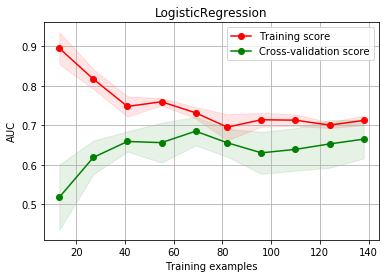

In [22]:
model = LogisticRegression()
plot_learning_curve(model, "LogisticRegression", X_train, Y_train, cv=10)
model.fit(X_train, Y_train)

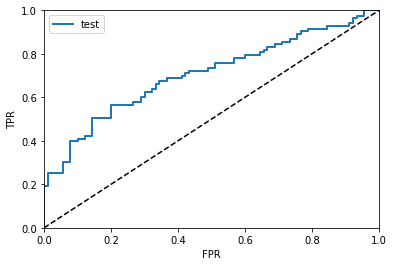

In [25]:
y_train_scores = model.decision_function(X_train)
fpr, tpr, thresholds = roc_curve(Y_train, y_train_scores)
plot_roc_curve([fpr], [tpr], "LogisticRegression", ["test"])

# May be a more complex model?

Epoch 1/100
217/217 [==============================] - 0s 822us/step - loss: 0.7260 - acc: 0.5253
Epoch 2/100
217/217 [==============================] - 0s 39us/step - loss: 0.7561 - acc: 0.5484
Epoch 3/100
217/217 [==============================] - 0s 48us/step - loss: 0.7053 - acc: 0.5622
Epoch 4/100
217/217 [==============================] - 0s 44us/step - loss: 0.7602 - acc: 0.4977
Epoch 5/100
217/217 [==============================] - 0s 59us/step - loss: 0.7038 - acc: 0.5576
Epoch 6/100
217/217 [==============================] - 0s 54us/step - loss: 0.7347 - acc: 0.4977
Epoch 7/100
217/217 [==============================] - 0s 54us/step - loss: 0.7697 - acc: 0.5161
Epoch 8/100
217/217 [==============================] - 0s 47us/step - loss: 0.7779 - acc: 0.5069
Epoch 9/100
217/217 [==============================] - 0s 81us/step - loss: 0.7559 - acc: 0.5115
Epoch 10/100
217/217 [==============================] - 0s 46us/step - loss: 0.7457 - acc: 0.4885
Epoch 11/100
217/217 [======

217/217 [==============================] - 0s 58us/step - loss: 0.6824 - acc: 0.5530
Epoch 83/100
217/217 [==============================] - 0s 47us/step - loss: 0.6946 - acc: 0.5530
Epoch 84/100
217/217 [==============================] - 0s 78us/step - loss: 0.7146 - acc: 0.5438
Epoch 85/100
217/217 [==============================] - 0s 55us/step - loss: 0.6936 - acc: 0.5484
Epoch 86/100
217/217 [==============================] - 0s 46us/step - loss: 0.6717 - acc: 0.5714
Epoch 87/100
217/217 [==============================] - 0s 47us/step - loss: 0.6838 - acc: 0.6083
Epoch 88/100
217/217 [==============================] - 0s 50us/step - loss: 0.6710 - acc: 0.5530
Epoch 89/100
217/217 [==============================] - 0s 51us/step - loss: 0.7035 - acc: 0.5576
Epoch 90/100
217/217 [==============================] - ETA: 0s - loss: 0.6796 - acc: 0.562 - 0s 75us/step - loss: 0.6937 - acc: 0.5069
Epoch 91/100
217/217 [==============================] - 0s 55us/step - loss: 0.7049 - acc: 0.

217/217 [==============================] - 0s 52us/step - loss: 0.7266 - acc: 0.4470
Epoch 64/100
217/217 [==============================] - 0s 52us/step - loss: 0.6690 - acc: 0.5853
Epoch 65/100
217/217 [==============================] - 0s 78us/step - loss: 0.7177 - acc: 0.5115
Epoch 66/100
217/217 [==============================] - 0s 67us/step - loss: 0.7224 - acc: 0.4931
Epoch 67/100
217/217 [==============================] - 0s 71us/step - loss: 0.6986 - acc: 0.5438
Epoch 68/100
217/217 [==============================] - 0s 65us/step - loss: 0.7118 - acc: 0.5438
Epoch 69/100
217/217 [==============================] - 0s 60us/step - loss: 0.6891 - acc: 0.5069
Epoch 70/100
217/217 [==============================] - 0s 64us/step - loss: 0.7246 - acc: 0.4470
Epoch 71/100
217/217 [==============================] - 0s 50us/step - loss: 0.7313 - acc: 0.5300
Epoch 72/100
217/217 [==============================] - 0s 60us/step - loss: 0.7215 - acc: 0.4885
Epoch 73/100
217/217 [===========

217/217 [==============================] - 0s 49us/step - loss: 0.7029 - acc: 0.5576
Epoch 46/100
217/217 [==============================] - 0s 49us/step - loss: 0.6897 - acc: 0.5714
Epoch 47/100
217/217 [==============================] - 0s 39us/step - loss: 0.7220 - acc: 0.5392
Epoch 48/100
217/217 [==============================] - 0s 47us/step - loss: 0.7227 - acc: 0.5023
Epoch 49/100
217/217 [==============================] - 0s 57us/step - loss: 0.7052 - acc: 0.5392
Epoch 50/100
217/217 [==============================] - 0s 58us/step - loss: 0.7015 - acc: 0.5760
Epoch 51/100
217/217 [==============================] - 0s 61us/step - loss: 0.6987 - acc: 0.5530
Epoch 52/100
217/217 [==============================] - ETA: 0s - loss: 0.6535 - acc: 0.625 - 0s 50us/step - loss: 0.6822 - acc: 0.5853
Epoch 53/100
217/217 [==============================] - 0s 52us/step - loss: 0.7257 - acc: 0.5161
Epoch 54/100
217/217 [==============================] - 0s 60us/step - loss: 0.7006 - acc: 0.

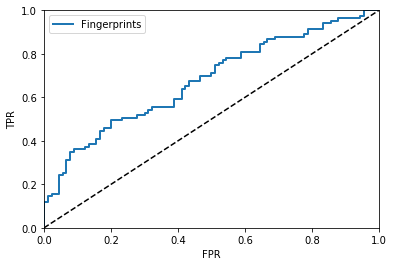

In [27]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.utils import np_utils
from keras import regularizers
from keras.optimizers import SGD

kfold = StratifiedKFold(n_splits=3, shuffle=True)
scores = []
for train, test in kfold.split(X_std, Y):
    model = Sequential()
    model.add(Dense(64, input_dim=X_std.shape[1], activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='sgd',
                  metrics=['accuracy'])
    model.fit(X_std, Y, epochs=100, batch_size=128)
    score = model.predict_proba(X_test)
    scores.append((roc_auc_score(Y_test, score)))

0.68% (+/- 0.06%)
173/173 [==============================] - 0s 32us/step


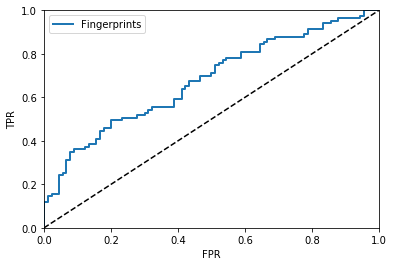

In [29]:
print("%.2f%% (+/- %.2f%%)" % (np.mean(scores), np.std(scores)))
score = model.predict_proba(X_train)
fpr, tpr, thresholds = roc_curve(Y_train, score)
plot_roc_curve([fpr], [tpr], "ANNFingerPrints", ["Fingerprints"])